In [13]:
import pickle
import numpy as np
import sympy
import pandas as pd
import sys
import time
sys.path.append('../../')
import cartpole_error_monitoring

def load_from_file(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        F = data['F']
        lmd_time_series = data['lmd_time_series']
        state_time_series = data['state_time_series']
    return F, lmd_time_series, state_time_series

F, lmd_time_series, state_time_series= load_from_file('symbolic_F.pkl')


In [14]:
for i in range(F.shape[1]):
    variables = set()
    matrix = F[i,0]
    variables.update(matrix.free_symbols)
    # print(list(variables))

for i in range(state_time_series.shape[0]):
    for j in range(state_time_series.shape[1]):
        variables = set()
        matrix = state_time_series[i,j]
        variables.update(matrix.free_symbols)
        # print(list(variables))

for i in range(lmd_time_series.shape[0]):
    for j in range(lmd_time_series.shape[1]):
        variables = set()
        matrix = lmd_time_series[i,j]
        variables.update(matrix.free_symbols)
        # print(list(variables))


In [15]:
# 読み込みたいファイル名のリスト
filenames = ['generated_code_uopt.log', 'generated_code_x.log', 'generated_code_t.log']

# 各ファイルを読み込み、その結果をリストに保存します
df_list = [pd.read_csv(filename, delim_whitespace=True, header=None) for filename in filenames]

# 各データフレームをnumpyの行列に変換し、それをリストに保存します
u_matrix, x_matrix, t = [df.values for df in df_list]


simulation step: 10000
0
computation time in 20 step: 33.449311
1
computation time in 20 step: 66.875529
2
computation time in 20 step: 100.201108
3
computation time in 20 step: 134.311755
4
computation time in 20 step: 168.005225
5
computation time in 20 step: 202.126053
6
computation time in 20 step: 235.546594
7
computation time in 20 step: 269.455907
8
computation time in 20 step: 303.217326
9
computation time in 20 step: 336.738947
10
computation time in 20 step: 370.804163
11
computation time in 20 step: 404.760060
12
computation time in 20 step: 438.545936
13
computation time in 20 step: 471.347009
14
computation time in 20 step: 504.942497
15
computation time in 20 step: 538.694675
16
computation time in 20 step: 572.058387
17
computation time in 20 step: 605.805593
18
computation time in 20 step: 639.289138
19
computation time in 20 step: 673.522862


Text(0.5, 0, 'Time (s)')

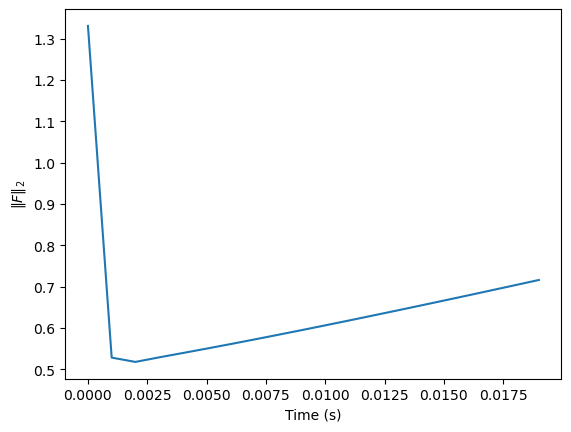

In [16]:
from math import sqrt

from matplotlib import pyplot as plt


config = {
    "nx": 4,  # Number of states
    "nu": 1,  # Number of control inputs
    "ocp_name": "generated_code",  # Name of the optimal control problem
    "Tf": 2.0,  # Time horizon for the optimal control problem
    "alpha": 0.0,  # Soft horizon parameter
    "sampling_time": 0.001,  # Sampling time for the discrete-time optimal control problem
    "N": 5,  # Number of discretized intervals
    "finite_difference_epsilon": 1.0e-08,  # Epsilon for finite difference approximations
    "zeta": 1000,  # Penalty parameter
    "kmax": 5,  # Maximum number of iterations for the semi-smooth Newton method
    "initial_time": 0,  # Initial time for the simulation
    "initial_state": [0, 0, 0, 0],  # Initial state for the simulation
    "simulation_length": 10,  # Length of the simulation in seconds
    "solution_initial_guess": [
        0.01
    ],  # Initial guess for the optimal control problem solution
    "tolerance": 1.0e-06,  # Tolerance for the optimal control problem solution
    "max_iterations": 50,  # Maximum number of iterations for the optimal control problem solution
}

# Create and configure the AutoGenU object
auto_gen_u = cartpole_error_monitoring.create_autogenu_object(config)
cartpole_error_monitoring.set_parameters(auto_gen_u, config)


["m_c", 2], ["m_p", 0.2], ["l", 0.5], ["g", 9.80665]
x = sympy.Matrix(sympy.symbols(f'x0:{config["nx"]}'))  # Initial state as variables
u = sympy.Matrix([sympy.symbols(f'u{i}_{j}') for i in range(config["nu"]) for j in range(config["N"])]).reshape(config["nu"], config["N"])
r = sympy.symbols('r[0:%d]' %(config["nu"]))
q_terminal = sympy.symbols('q_terminal[0:%d]' %(config["nx"]))
q = sympy.symbols('q[0:%d]' %(config["nx"]))
x_ref = sympy.symbols('x_ref[0:%d]' %(config["nx"]))


sub_param = auto_gen_u.make_subs_dicts()

# Create a list to store the L2 norms and F values
l2_norms = []
F_param_substituted = []

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
print("simulation step:", simulation_steps)
step = 20
start_time = time.time()
# for k in range(int(config["simulation_length"]/config["sampling_time"])):
for k in range(step):
    print(k)
    # Create the substitutions for the state and input at the current time step
    subs_x = [(x[l], x_matrix[k,l]) for l in range(config["nx"])]
    subs_u = [(u[l], u_matrix[k,l]) for l in range(config["N"])]

    # Create a list to store the F values for the current time step
    F_param_substituted_step = []

    # Loop over the control inputs
    norm = 0
    for i in range(config["N"]):
        for j in range(config["nu"]):
            # Calculate the value of F
            F_val = F[i,j].subs(sub_param).subs(subs_x).subs(subs_u)

            F_param = F[i,j].subs(sub_param)
            F_param_substituted_step.append(F_param)
            
            # Add to the squared L2 norm
            norm += F_val**2

    
    # if k%50 == 0:
    #     print(k)
    # Append the square root of the norm (i.e., the L2 norm) to the list
    l2_norms.append(sqrt(norm))
    end_time = time.time()
    print("computation time in %d step: %f" % (k, end_time - start_time))


    # Append the F values for the current step to the list
    # F_param_substituted.append(F_param_substituted_step)

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
t_series = [item for sublist in t[0:step] for item in sublist]
# Plot the L2 norm of F
plt.plot(t_series,l2_norms)
plt.ylabel(r'$\Vert F \Vert_2$')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

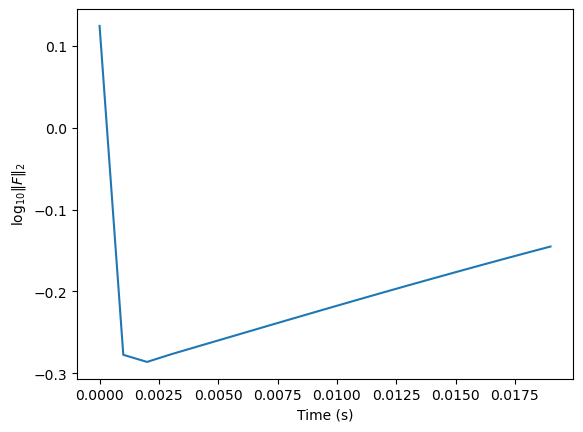

In [25]:
import numpy as np
arr = np.array(l2_norms)
result = np.log10(arr)
plt.plot(t_series,result)
plt.ylabel(r'$\log_{10}\Vert F \Vert_2$')
plt.xlabel('Time (s)')

simulation step: 10000
0
computation time in 20 step: 33.449311
1
computation time in 20 step: 66.875529
2
computation time in 20 step: 100.201108
3
computation time in 20 step: 134.311755
4
computation time in 20 step: 168.005225
5
computation time in 20 step: 202.126053
6
computation time in 20 step: 235.546594
7
computation time in 20 step: 269.455907
8
computation time in 20 step: 303.217326
9
computation time in 20 step: 336.738947
10
computation time in 20 step: 370.804163
11
computation time in 20 step: 404.760060
12
computation time in 20 step: 438.545936
13
computation time in 20 step: 471.347009
14
computation time in 20 step: 504.942497
15
computation time in 20 step: 538.694675
16
computation time in 20 step: 572.058387
17
computation time in 20 step: 605.805593
18
computation time in 20 step: 639.289138
19
computation time in 20 step: 673.522862


Text(0.5, 0, 'Time (s)')

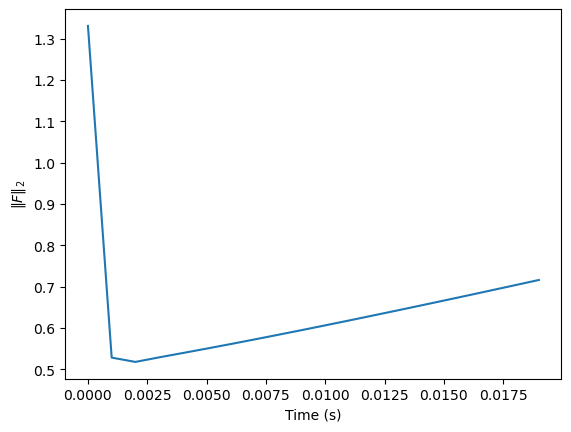

In [ ]:
from math import sqrt

from matplotlib import pyplot as plt


config = {
    "nx": 4,  # Number of states
    "nu": 1,  # Number of control inputs
    "ocp_name": "generated_code",  # Name of the optimal control problem
    "Tf": 2.0,  # Time horizon for the optimal control problem
    "alpha": 0.0,  # Soft horizon parameter
    "sampling_time": 0.001,  # Sampling time for the discrete-time optimal control problem
    "N": 5,  # Number of discretized intervals
    "finite_difference_epsilon": 1.0e-08,  # Epsilon for finite difference approximations
    "zeta": 1000,  # Penalty parameter
    "kmax": 5,  # Maximum number of iterations for the semi-smooth Newton method
    "initial_time": 0,  # Initial time for the simulation
    "initial_state": [0, 0, 0, 0],  # Initial state for the simulation
    "simulation_length": 10,  # Length of the simulation in seconds
    "solution_initial_guess": [
        0.01
    ],  # Initial guess for the optimal control problem solution
    "tolerance": 1.0e-06,  # Tolerance for the optimal control problem solution
    "max_iterations": 50,  # Maximum number of iterations for the optimal control problem solution
}

# Create and configure the AutoGenU object
auto_gen_u = cartpole_error_monitoring.create_autogenu_object(config)
cartpole_error_monitoring.set_parameters(auto_gen_u, config)


["m_c", 2], ["m_p", 0.2], ["l", 0.5], ["g", 9.80665]
x = sympy.Matrix(sympy.symbols(f'x0:{config["nx"]}'))  # Initial state as variables
u = sympy.Matrix([sympy.symbols(f'u{i}_{j}') for i in range(config["nu"]) for j in range(config["N"])]).reshape(config["nu"], config["N"])
r = sympy.symbols('r[0:%d]' %(config["nu"]))
q_terminal = sympy.symbols('q_terminal[0:%d]' %(config["nx"]))
q = sympy.symbols('q[0:%d]' %(config["nx"]))
x_ref = sympy.symbols('x_ref[0:%d]' %(config["nx"]))


sub_param = auto_gen_u.make_subs_dicts()

# Create a list to store the L2 norms and F values
l2_norms = []
F_param_substituted = []

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
print("simulation step:", simulation_steps)
step = 20
start_time = time.time()
# for k in range(int(config["simulation_length"]/config["sampling_time"])):
for k in range(step):
    print(k)
    # Create the substitutions for the state and input at the current time step
    subs_x = [(x[l], x_matrix[k,l]) for l in range(config["nx"])]
    subs_u = [(u[l], u_matrix[k,l]) for l in range(config["N"])]

    # Create a list to store the F values for the current time step
    F_param_substituted_step = []

    # Loop over the control inputs
    norm = 0
    for i in range(config["N"]):
        for j in range(config["nu"]):
            # Calculate the value of F
            F_val = F[i,j].subs(sub_param).subs(subs_x).subs(subs_u)

            F_param = F[i,j].subs(sub_param)
            F_param_substituted_step.append(F_param)
            
            # Add to the squared L2 norm
            norm += F_val**2

    
    # if k%50 == 0:
    #     print(k)
    # Append the square root of the norm (i.e., the L2 norm) to the list
    l2_norms.append(sqrt(norm))
    end_time = time.time()
    print("computation time in %d step: %f" % (k, end_time - start_time))


    # Append the F values for the current step to the list
    # F_param_substituted.append(F_param_substituted_step)

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
t_series = [item for sublist in t[0:step] for item in sublist]
# Plot the L2 norm of F
plt.plot(t_series,l2_norms)
plt.ylabel(r'$\Vert F \Vert_2$')
plt.xlabel('Time (s)')

In [17]:
from sympy import Matrix
from sympy.parsing.sympy_parser import parse_expr

# F_matrix = Matrix(config["N"], config["nu"], F_param_substituted)
# F = F_param_substituted[0][:]

# for i in range(config["N"]):
#     for j in range(config["nu"]):
#         variables = set()
#         matrix = F_param_substituted[i][j]
#         variables.update(matrix.free_symbols)
#         print(list(variables))

# for i in range(1):
#     F_matrix = Matrix(config["N"], config["nu"], F_param_substituted[i][:])
#     print(F_matrix)

# for i in range(config["N"]):
#     for j in range(config["nu"]):
#         variables = set()
#         matrix = F_param_substituted[i][j]
#         variables.update(matrix.free_symbols)
#         print(list(variables))




IndexError: list index out of range